<a href="https://colab.research.google.com/github/ElizabethEwurabena/CV_ENG_8160/blob/main/GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/CV_ENG_8160/module 6'

/content/drive/MyDrive/CV_ENG_8160/module 6


In [3]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
# #gdown is google drive download
# !gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
# !gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

Downloading...
From: https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN
To: /content/drive/MyDrive/CV_ENG_8160/module 6/train.zip
100% 8.67M/8.67M [00:00<00:00, 97.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i
To: /content/drive/MyDrive/CV_ENG_8160/module 6/test.zip
100% 459k/459k [00:00<00:00, 66.8MB/s]


In [ ]:
# !unzip 'train.zip' -d '.'
# !unzip 'test.zip' -d '.'

Archive:  train.zip
  inflating: ./tps_df.pkl            
  inflating: ./__MACOSX/._tps_df.pkl  
Archive:  test.zip
  inflating: ./test_data/tps_5.pkl   
  inflating: ./test_data/tps_2.pkl   
  inflating: ./test_data/tps_6.pkl   
  inflating: ./test_data/tps_4.pkl   
  inflating: ./test_data/tps_15.pkl  
  inflating: ./test_data/tps_7.pkl   
  inflating: ./test_data/tps_1.pkl   
  inflating: ./test_data/tps_12.pkl  
  inflating: ./test_data/tps_8.pkl   
  inflating: ./test_data/tps_3.pkl   
  inflating: ./test_data/tps_9.pkl   
  inflating: ./test_data/tps_13.pkl  
  inflating: ./test_data/tps_11.pkl  
  inflating: ./test_data/tps_10.pkl  
  inflating: ./test_data/tps_14.pkl  


In [6]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon,type):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []
        self.type = type
        self.train_df=None
        self.test_df=None


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        #split into 80% train 20% test
        train_len = int(0.8 * len(self.df))
        self.train_df = self.df.iloc[:train_len]
        self.test_df = self.df.iloc[train_len:]
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()

    def setup_forecast(self):
        if self.type == 'train':
            df = self.train_df
            print(len(df))
        elif self.type == 'test':
            df = self.test_df
            print(len(df))
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill") # 1 nan nan nan 2, fulfill 2
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]
                h = h_series[t:t+self.window]
                x_cat = np.dstack([x, h])
                self.inputs.append(x_cat)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window, 2)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [7]:
#36 x 36 -> window forecast
#forecast every 15 mins for the next 9 hours

tobj_train = TrafficForecast('tps_df.pkl',36,36,type='train')
tobj_test = TrafficForecast('tps_df.pkl',36,36,type='test')

1012749
253188


In [8]:
#1 x 36 x 2 hourxtrafficx

print(tobj_train.inputs[0].shape)
print(tobj_test.inputs[0].shape)

(1, 36, 2)
(1, 36, 2)


In [9]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx ==3:
        break

torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [12]:
for idx, data in enumerate(dataloader_test):
  # print(idx,data)
  print (data['inputs'].shape,data['outputs'].shape)
  if idx == 3:
      break

torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
from models import MyLSTM, MyGRU

LSTM

In [15]:

model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  for i_test,sample_test in enumerate(dataloader_test):
    outputs = model(sample_test['inputs'].to(device))
    test_loss = criterion(outputs, sample_test['outputs'].to(device))
    test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 33%|███▎      | 1/3 [01:10<02:21, 70.56s/it]

Epoch 1/3, Training Loss: 0.0512, Testing Loss: 0.0117


 67%|██████▋   | 2/3 [02:23<01:12, 72.08s/it]

Epoch 2/3, Training Loss: 0.0313, Testing Loss: 0.0117


100%|██████████| 3/3 [03:36<00:00, 72.04s/it]

Epoch 3/3, Training Loss: 0.0246, Testing Loss: 0.0117


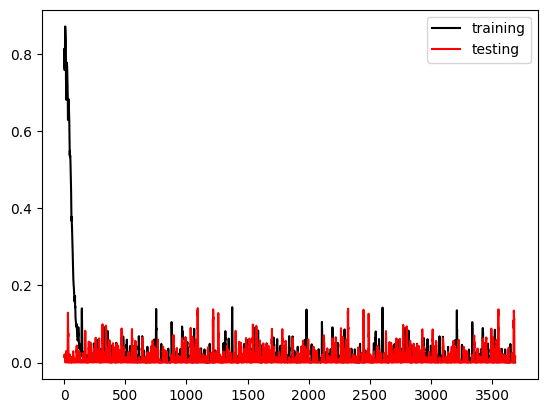

In [17]:
plt.plot(losses,'k',label='training')
plt.plot(test_losses,'r',label='testing')
plt.legend()

In [27]:

torch.save(model.state_dict(), 'LSTMmodel.pt')
LSTMmodel=MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
LSTMmodel.load_state_dict(torch.load('LSTMmodel.pt'))
LSTMmodel.eval()

MyLSTM(
  (relu): ReLU()
  (rnn): LSTM(2, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [29]:
def evaluation(model, dataloader_test, device):
    rmse = []
    maes = []
    model.eval()
    with torch.no_grad():
        for i_test, sample_test in enumerate(dataloader_test):
            inputs = sample_test['inputs'].to(device)
            targets = sample_test['outputs'].to(device)
            model.to(device)
            preds = model(inputs)
            error = ((preds - targets) ** 2).sum(1).mean().item()
            mae = (preds - targets).abs().sum(1).mean().item()
            rmse.append(math.sqrt(error))
            maes.append(mae)

    return {'rmse': np.mean(rmse), 'mae': np.mean(maes)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = evaluation(LSTMmodel, dataloader_test, device)
print(results)

{'rmse': 0.4527679226298743, 'mae': 1.3408634522339193}


GRU

In [30]:
model = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  for i_test,sample_test in enumerate(dataloader_test):
    outputs = model(sample_test['inputs'].to(device))
    test_loss = criterion(outputs, sample_test['outputs'].to(device))
    test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 33%|███▎      | 1/3 [01:21<02:42, 81.45s/it]

Epoch 1/3, Training Loss: 0.0595, Testing Loss: 0.0114


 67%|██████▋   | 2/3 [02:35<01:16, 76.93s/it]

Epoch 2/3, Training Loss: 0.0354, Testing Loss: 0.0115


100%|██████████| 3/3 [03:45<00:00, 75.25s/it]

Epoch 3/3, Training Loss: 0.0273, Testing Loss: 0.0115


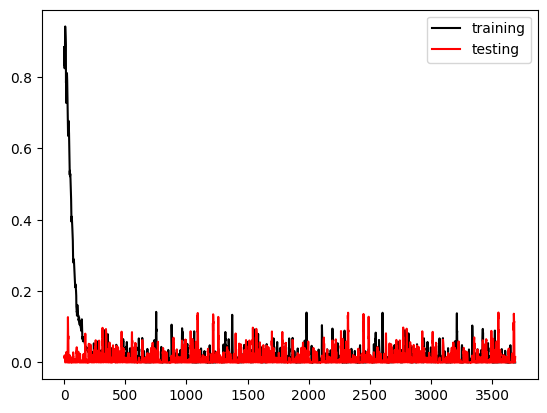

In [32]:
plt.plot(losses,'k',label='training')
plt.plot(test_losses,'r',label='testing')
plt.legend()

In [33]:
torch.save(model.state_dict(), 'GRUmodel.pt')
grumodel = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
grumodel.load_state_dict(torch.load('GRUmodel.pt'))
grumodel.eval()

MyGRU(
  (relu): ReLU()
  (rnn): GRU(2, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [34]:
def evaluation(model, dataloader_test, device):
    rmse = []
    maes = []
    model.eval()
    with torch.no_grad():
        for i_test, sample_test in enumerate(dataloader_test):
            inputs = sample_test['inputs'].to(device)
            targets = sample_test['outputs'].to(device)
            model.to(device)
            preds = model(inputs)
            error = ((preds - targets) ** 2).sum(1).mean().item()
            mae = (preds - targets).abs().sum(1).mean().item()
            rmse.append(math.sqrt(error))
            maes.append(mae)

    return {'rmse': np.mean(rmse), 'mae': np.mean(maes)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = evaluation(LSTMmodel, dataloader_test, device)
print(results)

{'rmse': 0.4527679226298743, 'mae': 1.3408634522339193}
